In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.datasets import load_digits

# Exercise 1

In [2]:
%%html
<div style="color: green; font-weight:bold"> Comment</div>

In [3]:
digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [4]:
def selected_items(target,data, images):#from 3,9
    selectedIndex =  [i for i, v in enumerate(target) if v == 3 or v == 9]# finding the index of 3,9 from the targets
    selectedTarget = [ v for i, v in enumerate(target) if i in selectedIndex]
    selectedImages =  [ v for i, v in enumerate(images) if i in selectedIndex]
    selectedData =  [ v for i, v in enumerate(data) if i in selectedIndex]
    return selectedTarget,selectedData,selectedImages
target_, data_, images_ = selected_items(target, data, images)

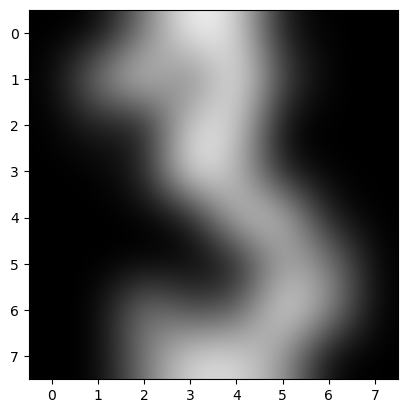

In [5]:
img =images_[0]
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img , interpolation = "bicubic")
plt.show()

# Exercise 2

In [6]:
X_all = data_
y_all = target_

X_train, X_test, y_train, y_test =\
    model_selection.train_test_split(data_, target_,
                                     test_size= 0.4, random_state = 0)

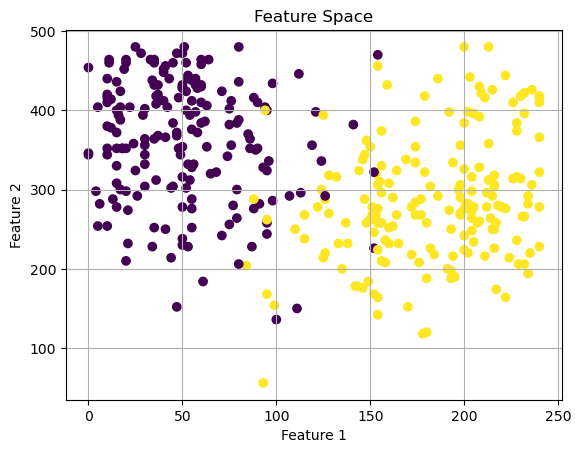

In [7]:
def features2d(data):
    features = []
    for i in range(len(data)):
        features.append([6*data[i][26] + 5*data[i][29] + 4*data[i][18], # feature 1: high value for '9's
                        12*data[i][36] + 8*data[i][21] + 10*data[i][4]])# feature 2: high value for '3's
    x1 = [features[i][0] for i in range(len(features))]
    x2 = [features[i][1] for i in range(len(features))]
    return features, x1, x2

features, x1, x2 = features2d(data_)
y= [i for i in range(len(features))]

plt.grid()
plt.scatter(x1, x2, c=y_all, cmap="viridis")
plt.title("Feature Space")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Plot showing the feature space. Yellow points are '9's, purple points are '3's

In [8]:
training_features, train_x1, train_x2 = features2d(X_train)
test_features, test_x1, test_x2 = features2d(X_test)

def nearest_mean(training_features, training_labels, test_features):
    training_x1 = [training_features[i][0] for i in range(len(training_features))]# class 9
    training_x2 = [training_features[i][1] for i in range(len(training_features))]# class 3
    # feature_ave1 = np.average(training_x1)
    # feature_ave2 = np.average(training_x2)

    predicted_labels =[]
    for i in range(len(test_features)):
        if test_features[i][0]>=100: # hand-picked criterion. Works better than nearest mean
        # if abs(test_features[i][0]-feature_ave1) <= abs(test_features[i][1]-feature_ave2): # nearest mean
            predicted_labels.append(1)
        else:
             predicted_labels.append(-1)
                
    return predicted_labels

predicted_labels = nearest_mean(training_features, y_train, test_features)

def errors(predicted_labels,true_labels):
    fp=0
    fn=0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == 1 and true_labels[i]==3:
            fp +=1
        elif predicted_labels[i] == -1 and true_labels[i]==9:
            fn +=1
    return print('The error is:{}'.format((fp+fn)/len(predicted_labels)))
errors(predicted_labels,y_test)

The error is:0.0547945205479452


As you can see, the error rate of the hand-picked features is already very good.

We could not get the visualization to work in time.

# Exercise 3

In [9]:
# renaming variables and redefining functions for code compatibility
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(y_train)
Y_test = np.array(y_test)

def features2d(x):
    feature_1 = lambda inst: 6*inst[26] + 5*inst[29] + 4*inst[18]
    feature_2 = lambda inst: 12*inst[36] + 8*inst[21] + 10*inst[4]

    return np.array([[feature_1(inst), feature_2(inst)] for inst in x])

def error_rate(predicted_labels, true_labels):
    #  Count the entries where the predicted label differs from the expected label
    f=0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] != true_labels[i]:
            f += 1

    return f/true_labels.shape[0]

In [10]:
def fit_lda(training_features, training_labels):
    mask_pos = np.array([t > 0 for t in training_labels])

    N = training_labels.shape[0]
    N_pos = training_labels[mask_pos].shape[0]

    # calculate means for positive and negative label
    mu_pos = np.sum(training_features[mask_pos], axis=0) / N_pos
    mu_neg = np.sum(training_features[~mask_pos], axis=0) / (N - N_pos)
    mu = np.array([mu_pos, mu_neg])

    # calculate covariance matrix
    vector_prod = lambda v: v * np.atleast_2d(v).T
    covmat_pos = sum(map(lambda X: vector_prod(X - mu_pos), training_features[mask_pos])) / N_pos
    covmat_neg = sum(map(lambda X: vector_prod(X - mu_neg), training_features[mask_pos])) / (N - N_pos)
    covmat = covmat_pos + covmat_neg

    # calculate the priors
    p = np.array([N_pos / N, (N - N_pos) / N])

    return mu, covmat, p

In [11]:
def predict_lda(mu, covmat, p, test_features):
    c_inv = np.linalg.pinv(covmat)

    mu_pos = np.atleast_2d(mu[0])
    mu_neg = np.atleast_2d(mu[1])

    beta = np.matmul(c_inv, mu_pos.T - mu_neg.T)
    b = (np.matmul(mu_neg, np.matmul(c_inv, mu_neg.T)) - np.matmul(mu_pos, np.matmul(c_inv, mu_pos.T))) / 2

    return np.sign(np.matmul(test_features, beta) + b).flatten()

In [12]:
# Convert the '3' and '9' labels into '-1' and '1'
Y_train_converted = np.vectorize(lambda i: i/3 - 2)(Y_train)
Y_test_converted = np.vectorize(lambda i: i/3 - 2)(Y_test)

In [13]:
# Apply the LDA fit function to feature data and full data
mu_feature, covmat_feature, p_feature = fit_lda(features2d(X_train), Y_train_converted)
mu_full, covmat_full, p_full = fit_lda(X_train, Y_train_converted)

In [14]:
# Predict training and test labels using LDA trained on
# both the 2D feature space and the full pixel space
predicted_training_labels_lda_feature = predict_lda(mu_feature, covmat_feature, p_feature, features2d(X_train))
predicted_test_labels_lda_feature = predict_lda(mu_feature, covmat_feature, p_feature, features2d(X_test))

predicted_training_labels_lda_full = predict_lda(mu_full, covmat_full, p_full, X_train)
predicted_test_labels_lda_full = predict_lda(mu_full, covmat_full, p_full, X_test)

In [15]:
print("Error rate of feature-trained LDA on training set: {:5.2f}%".format(error_rate(predicted_training_labels_lda_feature, Y_train_converted)*100))
print("Error rate of feature-trained LDA on test set:     {:5.2f}%".format(error_rate(predicted_test_labels_lda_feature, Y_test_converted)*100))
print()
print("Error rate of fully trained LDA on training set:   {:5.2f}%".format(error_rate(predicted_training_labels_lda_full, Y_train_converted)*100))
print("Error rate of fully trained LDA on test set:       {:5.2f}%".format(error_rate(predicted_test_labels_lda_full, Y_test_converted)*100))

Error rate of feature-trained LDA on training set:  5.07%
Error rate of feature-trained LDA on test set:      2.05%

Error rate of fully trained LDA on training set:    3.69%
Error rate of fully trained LDA on test set:        2.74%


We could not get the cross-validation and visualization to work in time

In [16]:
# Compare to LDA implementation by sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf_LDA = LDA()
clf_LDA.fit(X_train, Y_train_converted)
predicted_training_labels_sklearn_LDA = clf_LDA.predict(X_train)
predicted_test_labels_sklearn_LDA = clf_LDA.predict(X_test)

print("Error rate of sklearn-LDA on training set: {:5.2f}%".format(error_rate(predicted_training_labels_sklearn_LDA, Y_train_converted)*100))
print("Error rate of sklearn-LDA on test set:     {:5.2f}%".format(error_rate(predicted_test_labels_sklearn_LDA, Y_test_converted)*100))

Error rate of sklearn-LDA on training set:  0.46%
Error rate of sklearn-LDA on test set:      1.37%


# Exercise 4

In [17]:
def fit_svm_step(training_features, training_labels, lam, beta, b, tau):
    '''
    Performs one step of the SVM gradient descent algorithm
    '''
    N = training_labels.shape[0]
    mask_relu = np.array([training_labels[i] * (np.dot(training_features[i], beta) + b) < 1 for i in range(N)])

    del_beta = beta - lam/N * np.matmul(training_features[mask_relu].T, training_labels[mask_relu])
    del_b = - lam/N * np.sum(training_labels[mask_relu], axis=0)

    new_beta = beta - tau * del_beta
    new_b = b - tau*del_b

    return new_beta, new_b

In [18]:
def fit_svm(training_features, training_labels, lam, N_ITERATIONS=100):
    D = training_features.shape[1]
    # initial guess for beta and b
    beta = np.random.rand(D)
    b = np.random.rand()

    # choosing the step size as a sequence converging to zero
    tau = lambda t: 1 / (t + 1)

    # perform gradient descent 100 times
    for t in range(N_ITERATIONS):
        beta, b = fit_svm_step(training_features, training_labels, lam, beta, b, tau(t))
    
    return beta, b

In [19]:
def predict_svm(beta, b, test_features):
    return np.sign(np.matmul(test_features, beta) + b).flatten()

In [20]:
# Apply the SVM fit function to full pixel space with Lagrange multiplier 1
beta_full, b_full = fit_svm(X_train, Y_train_converted, 1)

In [21]:
# Predict training and test labels using SVM
predicted_training_labels_svm = predict_svm(beta_full, b_full, X_train)
predicted_test_labels_svm = predict_svm(beta_full, b_full, X_test)

In [22]:
print("Error rate of SVM on training set: {:5.2f}%".format(error_rate(predicted_training_labels_svm, Y_train_converted)*100))
print("Error rate of SVM on test set:     {:5.2f}%".format(error_rate(predicted_test_labels_svm, Y_test_converted)*100))

Error rate of SVM on training set:  0.46%
Error rate of SVM on test set:      0.00%


In [23]:
def track_error_of_svm(training_features, training_labels, test_features, test_labels, lam, N_ITERATIONS=100):
    '''
    Performs SVM gradient descent and calculates the error rate in each step
    '''
    errors = [0] * N_ITERATIONS

    D = training_features.shape[1]
    # initial guess for beta and b
    beta = np.random.rand(D)
    b = np.random.rand()

    # choosing the step size as a sequence converging to zero
    tau = lambda t: 1 / (t + 1)
    # tau = lambda t: .01 # constant step size performs worse

    for t in range(N_ITERATIONS):
        beta, b = fit_svm_step(training_features, training_labels, lam, beta, b, tau(t))
        predicted_labels = predict_svm(beta, b, test_features)
        errors[t] = error_rate(predicted_labels, test_labels)
    
    return beta, b, errors

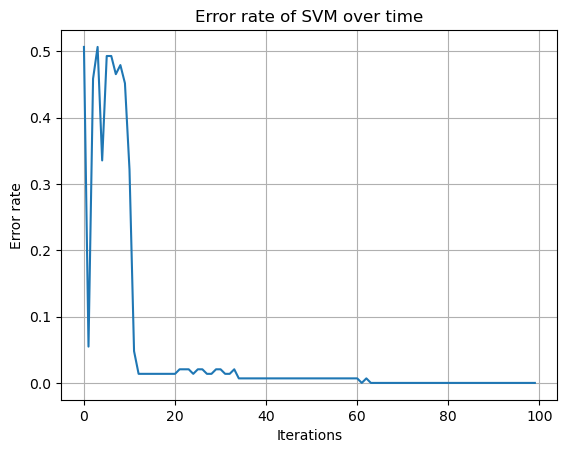

In [24]:
# Plot error of SVM for Lagrange multiplier 1
*_, errors = track_error_of_svm(X_train, Y_train_converted, X_test, Y_test_converted, 1)

plt.plot(list(range(100)), errors)
plt.grid()
plt.title("Error rate of SVM over time")
plt.xlabel("Iterations")
plt.ylabel("Error rate")
plt.show()

In [25]:
def cross_validation(training_features, training_labels, r_validation = .2, N_ITERATIONS=100):
    '''
    Uses part of the training set to check which Lagrange multiplier works best.
    '''
    N = training_labels.shape[0]

    # choose some fixed fraction of the training set to be the validation set
    mask_validation = np.array([(t > (1 - r_validation)*N) for t in range(N)])
    candidates = [10**k for k in range(-2, 3)]

    best_error = float('inf')
    best_candidate = [None, None, None] # will contain, lam, error, beta, and b

    for lam in candidates:
        beta, b = fit_svm(training_features[~mask_validation], training_labels[~mask_validation], lam, N_ITERATIONS)

        predicted_labels = predict_svm(beta, b, training_features[mask_validation])
        error = error_rate(predicted_labels, training_labels[mask_validation])

        if error < best_error:
            best_candidate = [lam, beta, b]
            best_error = error
    
    return best_candidate

In [26]:
lam_cv, *_ = cross_validation(X_train, Y_train)
print(lam_cv) # print the parameter deemed best by the algorithm

0.01


Apparently a low value for lambda is advantageous for this model

We could not get the visualization to work in time

In [27]:
# Compare to SVM implementation by sklearn
from sklearn import svm

clf_SVM = svm.SVC()
clf_SVM.fit(X_train, Y_train_converted)

predicted_training_labels_sklearn_SVM = clf_SVM.predict(X_train)
predicted_test_labels_sklearn_SVM = clf_SVM.predict(X_test)

print("Error rate of sklearn-SVM on training set: {:5.2f}%".format(error_rate(predicted_training_labels_sklearn_SVM, Y_train_converted)*100))
print("Error rate of sklearn-SVM on test set:     {:5.2f}%".format(error_rate(predicted_test_labels_sklearn_SVM, Y_test_converted)*100))

Error rate of sklearn-SVM on training set:  0.46%
Error rate of sklearn-SVM on test set:      0.00%
